<a href="https://colab.research.google.com/github/KavinilaLoganathan-2507/AgileProjectBoard/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow opencv-python matplotlib scikit-learn tqdm

In [3]:
import os
import random
import shutil
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications, callbacks
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [6]:
import tensorflow_datasets as tfds # Import tensorflow_datasets

# If using TFDS, convert dataset into directory structure expected by Keras ImageDataGenerator.
USE_TFDS = True

BASE_DIR = "cv_binary_data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Clean up if exists
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(VAL_DIR)
os.makedirs(TEST_DIR)

for c in ['cats','dogs']:
    os.makedirs(os.path.join(TRAIN_DIR, c))
    os.makedirs(os.path.join(VAL_DIR, c))
    os.makedirs(os.path.join(TEST_DIR, c))

if USE_TFDS:
    # Define ds_full by loading a dataset, for example 'cats_vs_dogs'
    # You might need to adjust the dataset name based on your requirements.
    ds_full, ds_info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

    # Take a subset to keep sizes small for demonstration
    MAX_PER_CLASS_TRAIN = 800
    MAX_PER_CLASS_VAL = 200
    MAX_PER_CLASS_TEST = 100

    counts = {'cats':0, 'dogs':0}
    counts_val = {'cats':0, 'dogs':0}
    counts_test = {'cats':0, 'dogs':0}

    for img, label in tfds.as_numpy(ds_full['train']): # Corrected to iterate over the 'train' split
        cls = 'cats' if label==0 else 'dogs'
        # convert to BGR (opencv uses BGR) then save
        if counts[cls] < MAX_PER_CLASS_TRAIN:
            phase='train'; counts[cls]+=1
        elif counts_val[cls] < MAX_PER_CLASS_VAL:
            phase='val'; counts_val[cls]+=1
        elif counts_test[cls] < MAX_PER_CLASS_TEST:
            phase='test'; counts_test[cls]+=1
        else:
            continue
        dst = os.path.join(BASE_DIR, phase, cls, f"{cls}_{phase}_{counts[cls]+counts_val[cls]+counts_test[cls]}.jpg")
        # img is RGB uint8; convert to BGR before cv2.imwrite for consistency (not strictly required)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dst, img_bgr)

# Show how many images we have
for phase in ['train','val','test']:
    for cls in ['cats','dogs']:
        print(phase, cls, len(os.listdir(os.path.join(BASE_DIR, phase, cls))))

train cats 800
train dogs 800
val cats 200
val dogs 200
test cats 100
test dogs 100


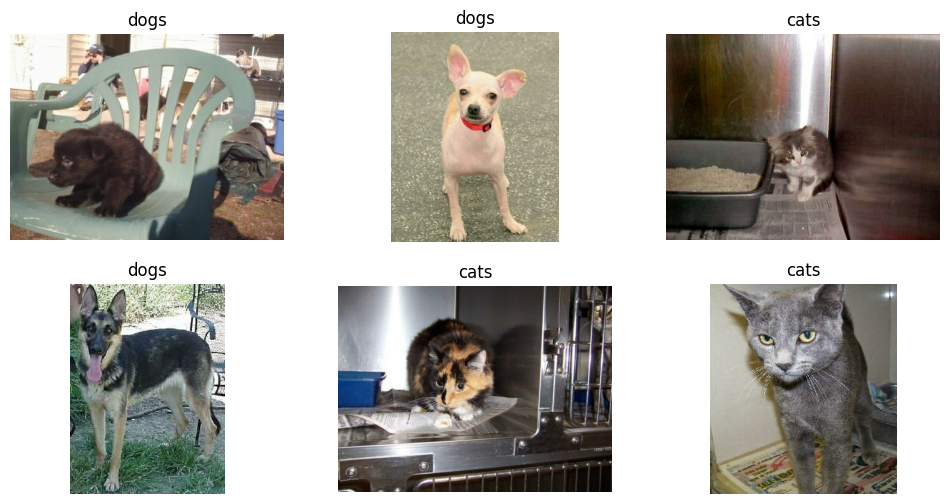

In [7]:
def show_samples(folder, n=6):
    files = []
    for cls in ['cats','dogs']:
        files += glob(os.path.join(folder, cls, '*.jpg'))[:n//2]
    random.shuffle(files)
    plt.figure(figsize=(12,6))
    for i,f in enumerate(files):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(f).split('_')[0])
        plt.axis('off')
    plt.show()

show_samples(os.path.join(BASE_DIR, 'train'), n=6)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR,'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(BASE_DIR,'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    os.path.join(BASE_DIR,'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


In [9]:
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                      include_top=False,
                                      weights='imagenet')
base_model.trainable = False  # freeze for initial training

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Define callbacks
checkpoint_cb = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss', min_lr=1e-7)

# Unfreeze top layers of base model
base_model.trainable = True
# Freeze all layers up to a certain layer
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

EPOCHS_FINE = 8
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)
# Save final weights
model.save("final_model.h5")

Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9262 - loss: 0.2418 - precision: 0.9156 - recall: 0.9394

50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9263 - loss: 0.2415 - precision: 0.9159 - recall: 0.9393 - val_accuracy: 0.9775 - val_loss: 0.1056 - val_precision: 0.9897 - val_recall: 0.9650 - learning_rate: 1.0000e-05
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9560 - loss: 0.1696 - precision: 0.9580 - recall: 0.9524

50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9559 - loss: 0.1695 - precision: 0.9579 - recall: 0.9524 - val_accuracy: 0.9800 - val_loss: 0.0833 - val_precision: 0.9898 - val_recall: 0.9700 - learning_rate: 1.0000e-05
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9446 - loss: 0.1542 - precision: 0.9556 - recall: 0.9321

50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9447 - loss: 0.1540 - precision: 0.9556 - recall: 0.9324 - val_accuracy: 0.9800 - val_loss: 0.0731 - val_precision: 0.9898 - val_recall: 0.9700 - learning_rate: 1.0000e-05
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - loss: 0.1227 - precision: 0.9764 - recall: 0.9556

50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9655 - loss: 0.1226 - precision: 0.9761 - recall: 0.9557 - val_accuracy: 0.9775 - val_loss: 0.0654 - val_precision: 0.9848 - val_recall: 0.9700 - learning_rate: 1.0000e-05
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - loss: 0.1204 - precision: 0.9710 - recall: 0.9567

50/50 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9631 - loss: 0.1202 - precision: 0.9710 - recall: 0.9568 - val_accuracy: 0.9775 - val_loss: 0.0596 - val_precision: 0.9848 - val_recall: 0.9700 - learning_rate: 1.0000e-05
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - loss: 0.0974 - precision: 0.9710 - recall: 0.9570

50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9644 - loss: 0.0972 - precision: 0.9710 - recall: 0.9572 - val_accuracy: 0.9775 - val_loss: 0.0573 - val_precision: 0.9848 - val_recall: 0.9700 - learning_rate: 1.0000e-05
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9706 - loss: 0.0863 - precision: 0.9705 - recall: 0.9701

50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9706 - loss: 0.0861 - precision: 0.9707 - recall: 0.9702 - val_accuracy: 0.9800 - val_loss: 0.0553 - val_precision: 0.9848 - val_recall: 0.9750 - learning_rate: 1.0000e-05
Epoch 8/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9649 - loss: 0.0936 - precision: 0.9713 - recall: 0.9562

50/50 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9649 - loss: 0.0934 - precision: 0.9713 - recall: 0.9563 - val_accuracy: 0.9800 - val_loss: 0.0548 - val_precision: 0.9800 - val_recall: 0.9800 - learning_rate: 1.0000e-05


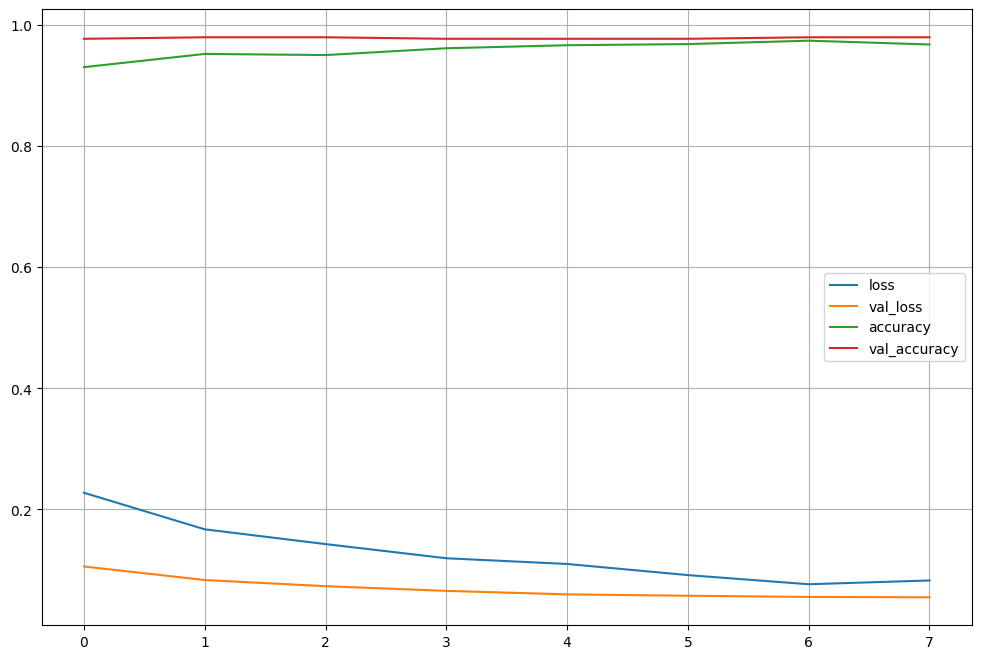

In [14]:
def plot_history(hists, keys=['loss','val_loss','accuracy','val_accuracy']):
    plt.figure(figsize=(12,8))
    for k in keys:
        plt.plot(hists.history.get(k) if hasattr(hists,'history') else hists.get(k), label=k)
    plt.legend(); plt.grid(True); plt.show()

# If you have two histories, combine or plot separately
# plot_history(history, keys=['loss','val_loss','accuracy','val_accuracy'])
plot_history(history_fine, keys=['loss','val_loss','accuracy','val_accuracy'])

In [15]:
# Predict on test set
test_steps = int(np.ceil(test_gen.samples / BATCH_SIZE))
y_pred_prob = model.predict(test_gen, steps=test_steps)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

y_true = test_gen.classes  # labels in order
# If generator length > predicted, slice
y_pred = y_pred[:len(y_true)]

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['cat','dog']))

# Precision / recall numeric
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Confusion Matrix:
 [[99  1]
 [ 1 99]]

Classification Report:
               precision    recall  f1-score   support

         cat       0.99      0.99      0.99       100
         dog       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Precision: 0.9900, Recall: 0.9900


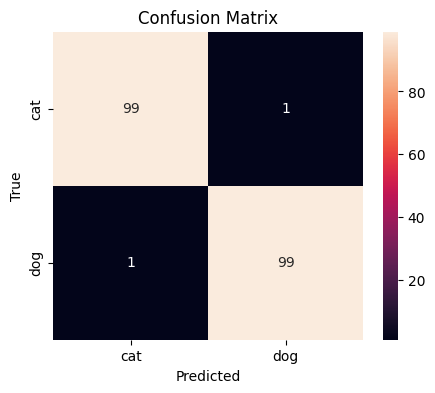

In [16]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['cat','dog'], yticklabels=['cat','dog'])
plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


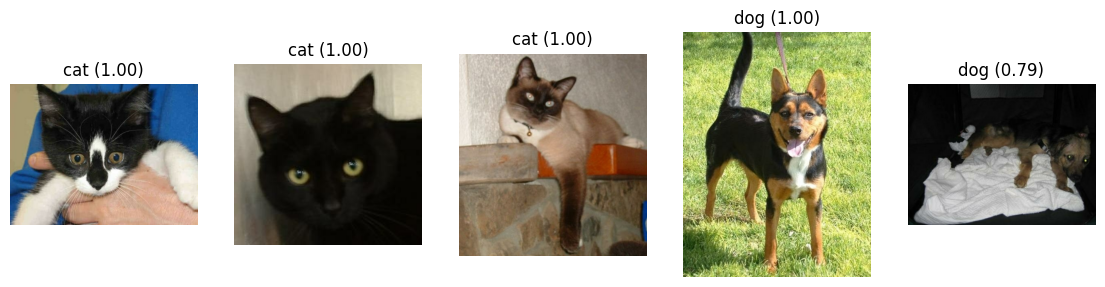

In [19]:
INF_DIR = "inference_images"
os.makedirs(INF_DIR, exist_ok=True)
# For demo, copy 5 test images into INF_DIR or place your own images.

inf_files = glob(os.path.join(INF_DIR, '*.jpg'))
# If none provided, pick a few from test set (for demo)
if len(inf_files) < 5:
    inf_files = glob(os.path.join(BASE_DIR, 'test', 'cats', '*.jpg'))[:3] + glob(os.path.join(BASE_DIR, 'test', 'dogs', '*.jpg'))[:3]
    inf_files = inf_files[:5]

plt.figure(figsize=(14,6))
for i,f in enumerate(inf_files):
    orig = cv2.imread(f)
    rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    img = cv2.resize(rgb, IMG_SIZE)
    x = img.astype('float32')/255.0
    x = np.expand_dims(x, axis=0)
    prob = model.predict(x)[0][0]
    label = 'dog' if prob>=0.5 else 'cat'
    conf = prob if prob>=0.5 else 1-prob
    plt.subplot(1,5,i+1)
    plt.imshow(rgb)
    plt.title(f"{label} ({conf:.2f})")
    plt.axis('off')
plt.show()
